In [1]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam
import matplotlib.pyplot as plt
import pickle
import sys; sys.path.insert(0, "..")
from game import *
from agents import *
from checkers import *

In [2]:
n_train_games = 1000
n_train_games_post_reversal = 1000
max_moves = 500
n_decay = 10
n_games_test = 10
test_frequency = 10
max_random_start_depth_train = 3
max_random_start_depth_test = 3
gamma = 0.7
initial_alpha = 0.001
initial_epsilon = 0.35

In [3]:
filename = '..\data\Experiment_SARSAlambda_05_checker_reward_mix_oppn_reverse_rule_at_1000_manual_tuning_alpha_eps.pkl'
with open(filename, 'rb') as handle:
    data = pickle.load(handle)
data.keys()    

dict_keys(['pool_results', 'pool_draws', 'pool_oppn_idx', 'pool_weights', 'pool_num', 'pool_rewards', 'pool_td', 'pool_test_results_rand', 'pool_test_results_1', 'pool_test_results_2', 'pool_test_results_3', 'pool_test_draws_rand', 'pool_test_draws_1', 'pool_test_draws_2', 'pool_test_draws_3'])

In [4]:
# filename = '..\data\Experiment_SARSA_11_features_checker_reward_mix_oppn_reverse_rule_at_1000_manual_tuning_alpha_eps.pkl'
# with open(filename, 'rb') as handle:
#     data = pickle.load(handle)

In [5]:
all_td = np.stack(data['pool_td'],axis=1)
all_rewards = np.stack(data['pool_rewards'],axis=1)
# all_td = np.stack(data['pool_rewards'],axis=1)

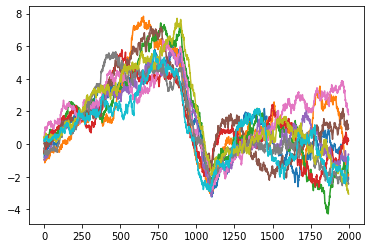

In [6]:
w = 200
calib = np.convolve(np.ones(all_td.shape[0]), np.ones(w), 'same')

for i in range(10):
    plt.plot(range(2000), np.convolve(all_td[:,i], np.ones(w), 'same') / calib);
# plt.plot(range(2000), np.convolve(all_rewards[:,0], np.ones(w), 'same') / calib);

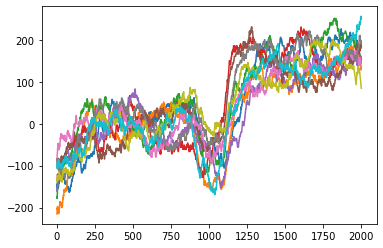

In [7]:
for i in range(10):
    plt.plot(range(2000), np.convolve(all_rewards[:,i], np.ones(w), 'same') / calib);

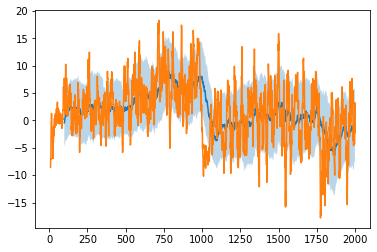

In [8]:
i = 2
w1 = 100
w2 = 10
calib1 = np.convolve(np.ones(all_td.shape[0]), np.ones(w1), 'valid')
calib2 = np.convolve(np.ones(all_td.shape[0]), np.ones(w2), 'valid')
smooth_td_1 = np.convolve(all_td[:,i], np.ones(w1), 'valid') / calib1
smooth_td_2 = np.convolve(all_td[:,i], np.ones(w2), 'valid') / calib2
td_sd = np.empty(2000-w1+1)
for t in range(len(td_sd)):
    td_sd[t] =0.4*np.std(all_td[t:t+w1-1-w2,i])

plt.plot(np.arange(w1-1,2000),smooth_td_1);
plt.fill_between(np.arange(w1-1,2000),smooth_td_1-td_sd,smooth_td_1+td_sd,alpha=0.3)

plt.plot(np.arange(w2-1,2000), np.convolve(all_td[:,i], np.ones(w2), 'valid') / calib2);

In [9]:
td_2sd = np.empty(2000-w1+1)
for t in range(len(td_2sd)):
    td_2sd[t] = np.std(all_td[t:t+w1-1,i])

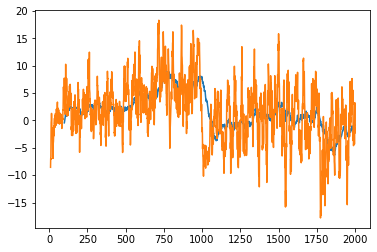

In [10]:
plt.plot(np.arange(w1-1,2000), np.convolve(all_td[:,i], np.ones(w1), 'valid') / calib1);
plt.plot(np.arange(w2-1,2000), np.convolve(all_td[:,i], np.ones(w2), 'valid') / calib2);

In [58]:
n_features = 34
feature_func = checkers_features_augmented

reward_function = checkers_reward
reverse_reward_function = reverse_checkers_reward

ab1 = AlphaBetaAgent(1)
ab2 = AlphaBetaAgent(2)
ab3 = AlphaBetaAgent(3)
rand_agent = RandomAgent()
# second_agent_list = [ab1, ab2, ab3, rand_agent]
second_agent_list = [ab1, rand_agent]

ab1_r = AlphaBetaAgent(1, reward_direction=-1)
ab2_r = AlphaBetaAgent(2, reward_direction=-1)
ab3_r = AlphaBetaAgent(3, reward_direction=-1)        
# second_agent_list_post_reversal = [ab1_r, ab2_r, ab3_r, rand_agent]
second_agent_list_post_reversal = [ab1_r, rand_agent]

quiet = True
n_train_games = 500
n_train_games_post_reversal = 500
max_moves = 500
n_decay = 1
n_games_test = 10
test_frequency = 10
max_random_start_depth_train = 3
max_random_start_depth_test = 3
gamma = 0.7
initial_alpha = 0.001
initial_epsilon = 0.35
min_alpha = 1e-5
min_epsilon = 0.01
alpha_decay_rate = 0.995
epsilon_decay_rate = 0.995
alpha_recovery_rate = 1.05
epsilon_recovery_rate = 1.05

w1 = 100
w2 = 10
sd_frac = 0.5

In [59]:
pool_results = []
pool_draws = []
pool_oppn_idx = []
pool_weights = []
pool_rewards = []
pool_td = []
pool_num = []
pool_test_results_rand = []
pool_test_results_1 = []
pool_test_results_2 = []
pool_test_results_3 = []
pool_test_draws_rand = []
pool_test_draws_1 = []
pool_test_draws_2 = []
pool_test_draws_3 = []

pool_td1_mean = []
pool_td1_sd = []
pool_td2_mean = []

pool_alpha = []
pool_epsilon = []
    
for i_trial in [0]:
    print('Trial =', i_trial)
    
    np.random.seed(i_trial)
    initial_weights = np.random.normal(size=n_features)
    first_agent = SarsaLearningAgent(feature_func, n_features, reward_function = reward_function, 
                                     alpha=initial_alpha, gamma=gamma, epsilon=initial_epsilon, 
                                     is_learning_agent=True, weights=initial_weights)

    all_results = []
    all_draws = []
    all_oppn_idx = []
    all_weights = []
    all_rewards = []
    all_td = []
    all_num = []
    test_results_rand = []
    test_results_1 = []
    test_results_2 = []
    test_results_3 = []
    test_draws_rand = []
    test_draws_1 = []
    test_draws_2 = []
    test_draws_3 = []
    
    all_td1_mean = []
    all_td1_sd = []
    all_td2_mean = []
    all_alpha = []
    all_epsilon = []

    # pre-training test
    this_test_results_rand = []
    this_test_results_1 = []
    this_test_results_2 = []
    this_test_results_3 = []

    this_test_draws_rand = []
    this_test_draws_1 = []
    this_test_draws_2 = []
    this_test_draws_3 = []

    for n in range(n_games_test):
        test_agent = SarsaLearningAgent(feature_func, n_features, reward_function = reward_function, alpha=0., gamma=gamma, epsilon=initial_epsilon, is_learning_agent=False, weights=initial_weights)
        # play against ab1
        first_agent_turn = bool(np.random.binomial(1,0.5))
        rules = ClassicGameRules(max_moves=max_moves)
        game = rules.new_game(test_agent, ab1, first_agent_turn, quiet=quiet)

        # random start
        random_start_spots = game.game_state.board.spots
        for _ in range(np.random.choice(max_random_start_depth_test)*2):
            possible_moves = game.game_state.board.get_possible_next_moves()
            next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
            game.game_state.board.make_move(next_move, switch_player_turn=True)
            random_start_spots = game.game_state.board.spots

        num_moves, game_state = game.run()
        this_test_results_1.append(game_state.is_first_agent_win())
        this_test_draws_1.append(game_state.max_moves_done)

#         # play against ab2
#         first_agent_turn = bool(np.random.binomial(1,0.5))
#         rules = ClassicGameRules(max_moves=max_moves)
#         game = rules.new_game(test_agent, ab2, first_agent_turn, quiet=quiet)
#         game.game_state.board.spots = random_start_spots # set start board position to the same random start
#         num_moves, game_state = game.run()
#         this_test_results_2.append(game_state.is_first_agent_win())
#         this_test_draws_2.append(game_state.max_moves_done)

#         # play against ab3
#         first_agent_turn = bool(np.random.binomial(1,0.5))
#         rules = ClassicGameRules(max_moves=max_moves)
#         game = rules.new_game(test_agent, ab3, first_agent_turn, quiet=quiet)
#         game.game_state.board.spots = random_start_spots # set start board position to the same random start
#         num_moves, game_state = game.run()
#         this_test_results_3.append(game_state.is_first_agent_win())
#         this_test_draws_3.append(game_state.max_moves_done)

        # play against random agent
        first_agent_turn = bool(np.random.binomial(1,0.5))
        rules = ClassicGameRules(max_moves=max_moves)
        game = rules.new_game(test_agent, rand_agent, first_agent_turn, quiet=quiet)
        game.game_state.board.spots = random_start_spots # set start board position to the same random start
        num_moves, game_state = game.run()
        this_test_results_rand.append(game_state.is_first_agent_win())
        this_test_draws_rand.append(game_state.max_moves_done)

    test_results_1.append(np.mean(np.array(this_test_results_1)))
#     test_results_2.append(np.mean(np.array(this_test_results_2)))
#     test_results_3.append(np.mean(np.array(this_test_results_3)))
    test_results_rand.append(np.mean(np.array(this_test_results_rand)))

    test_draws_1.append(np.mean(np.array(this_test_draws_1)))
#     test_draws_2.append(np.mean(np.array(this_test_draws_2)))
#     test_draws_3.append(np.mean(np.array(this_test_draws_3)))
    test_draws_rand.append(np.mean(np.array(this_test_draws_rand)))


    # training with standard rule
    for n in range(n_train_games):
        if n > w1:
            mean_td_1 = np.mean(all_td[-w1:])
            sd_td_1 = np.std(all_td[-w1:])
            mean_td_2 = np.mean(all_td[-w2:])
            
            all_td1_mean.append(mean_td_1)
            all_td1_sd.append(sd_td_1)
            all_td2_mean.append(mean_td_2)
            # increase learning rate if TD decreased
            if mean_td_2 < (mean_td_1 - sd_frac*sd_td_1):
                factor = (mean_td_1 - mean_td_2)/(sd_frac*sd_td_1)
                current_alpha = first_agent.alpha
                current_epsilon = first_agent.epsilon
                first_agent.alpha = min([(alpha_recovery_rate**factor)*current_alpha, initial_alpha])
                first_agent.epsilon = min([(alpha_recovery_rate**factor)*current_epsilon, initial_epsilon])
                print('Ajusting alpha from {0:.6f} to {1:.6f}'.format(current_alpha,first_agent.alpha))
                print('Ajusting epsilon from {0:.6f} to {1:.6f}'.format(current_epsilon,first_agent.epsilon))
                
            # change alpha and epsilon after n_decay games
            elif n%n_decay == n_decay-1:
                first_agent.alpha = max([alpha_decay_rate*first_agent.alpha, min_alpha])
                first_agent.epsilon = max([epsilon_decay_rate*first_agent.epsilon, min_epsilon])

#         if n%50 == 0: print(n)
        # train against randomly selected agent
        first_agent_turn = bool(np.random.binomial(1,0.5))

        second_agent_idx = np.random.choice(len(second_agent_list))  
        all_oppn_idx.append(second_agent_idx)
        second_agent = second_agent_list[second_agent_idx]

        rules = ClassicGameRules(max_moves=max_moves)
        game = rules.new_game(first_agent, second_agent, first_agent_turn, quiet=quiet)    

        # random start
        for _ in range(np.random.choice(max_random_start_depth_train)*2):
            possible_moves = game.game_state.board.get_possible_next_moves()
            next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
            game.game_state.board.make_move(next_move, switch_player_turn=True)

        num_moves, game_state = game.run()

        all_num.append(num_moves)
        all_rewards.append(first_agent.episode_rewards)
        all_td.append(first_agent.episode_td_history[-1])
        all_results.append(game_state.is_first_agent_win())
        all_draws.append((game_state.max_moves_done))
        all_weights.append(first_agent.weights.copy())
        all_alpha.append(first_agent.alpha)
        all_epsilon.append(first_agent.epsilon)

        if n%test_frequency == test_frequency-1:

            this_test_results_rand = []
            this_test_results_1 = []
            this_test_results_2 = []
            this_test_results_3 = []

            this_test_draws_rand = []
            this_test_draws_1 = []
            this_test_draws_2 = []
            this_test_draws_3 = []

            for _ in range(n_games_test):
                current_epislon = first_agent.epsilon
                test_agent = SarsaLearningAgent(feature_func, n_features, reward_function = reward_function, alpha=0., gamma=gamma, epsilon=current_epislon, is_learning_agent=False, weights=all_weights[-1])
                # play against ab1
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, ab1, first_agent_turn, quiet=quiet)

                # random start
                random_start_spots = game.game_state.board.spots
                for _ in range(np.random.choice(max_random_start_depth_test)*2):
                    possible_moves = game.game_state.board.get_possible_next_moves()
                    next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
                    game.game_state.board.make_move(next_move, switch_player_turn=True)
                    random_start_spots = game.game_state.board.spots

                num_moves, game_state = game.run()
                this_test_results_1.append(game_state.is_first_agent_win())
                this_test_draws_1.append(game_state.max_moves_done)

#                 # play against ab2
#                 first_agent_turn = bool(np.random.binomial(1,0.5))
#                 rules = ClassicGameRules(max_moves=max_moves)
#                 game = rules.new_game(test_agent, ab2, first_agent_turn, quiet=quiet)
#                 game.game_state.board.spots = random_start_spots # set start board position to the same random start
#                 num_moves, game_state = game.run()
#                 this_test_results_2.append(game_state.is_first_agent_win())
#                 this_test_draws_2.append(game_state.max_moves_done)

#                 # play against ab3
#                 first_agent_turn = bool(np.random.binomial(1,0.5))
#                 rules = ClassicGameRules(max_moves=max_moves)
#                 game = rules.new_game(test_agent, ab3, first_agent_turn, quiet=quiet)
#                 game.game_state.board.spots = random_start_spots # set start board position to the same random start
#                 num_moves, game_state = game.run()
#                 this_test_results_3.append(game_state.is_first_agent_win())
#                 this_test_draws_3.append(game_state.max_moves_done)

                # play against random agent
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, rand_agent, first_agent_turn, quiet=quiet)
                game.game_state.board.spots = random_start_spots # set start board position to the same random start
                num_moves, game_state = game.run()
                this_test_results_rand.append(game_state.is_first_agent_win())
                this_test_draws_rand.append(game_state.max_moves_done)

            test_results_1.append(np.mean(np.array(this_test_results_1)))
#             test_results_2.append(np.mean(np.array(this_test_results_2)))
#             test_results_3.append(np.mean(np.array(this_test_results_3)))
            test_results_rand.append(np.mean(np.array(this_test_results_rand)))

            test_draws_1.append(np.mean(np.array(this_test_draws_1)))
#             test_draws_2.append(np.mean(np.array(this_test_draws_2)))
#             test_draws_3.append(np.mean(np.array(this_test_draws_3)))
            test_draws_rand.append(np.mean(np.array(this_test_draws_rand)))

            print('Post game', n,'wins = ',test_results_1[-1],test_results_rand[-1])    
            print('Post game', n,'draws = ',test_draws_1[-1],test_draws_rand[-1]) 
            
#             print('Post game', n, 'wins = ',test_results_1[-1],test_results_2[-1],test_results_3[-1],test_results_rand[-1])    
#             print('Post game', n,'draws = ',test_draws_1[-1],test_draws_2[-1],test_draws_3[-1],test_draws_rand[-1])  
            
  
    
    #### set reverse rule (in ClassicGameRules.new_game)
    reverse = True

    # RL agent: takes reverse reward
    first_agent = SarsaLearningAgent(feature_func, n_features, reward_function = reverse_reward_function, 
                                     alpha=all_alpha[-1], gamma=gamma, epsilon=all_epsilon[-1], 
                                     is_learning_agent=True, weights=all_weights[n_train_games-1])
    
    # train with reverse rule
    for n in range(n_train_games_post_reversal):    
        # start readjusting mechanism immediately
        mean_td_1 = np.mean(all_td[-w1:])
        sd_td_1 = np.std(all_td[-w1:])
        mean_td_2 = np.mean(all_td[-w2:])

        all_td1_mean.append(mean_td_1)
        all_td1_sd.append(sd_td_1)
        all_td2_mean.append(mean_td_2)

        # increase learning rate if TD decreased
        if mean_td_2 < (mean_td_1 - sd_frac*sd_td_1):
            factor = (mean_td_1 - mean_td_2)/(sd_frac*sd_td_1)
            current_alpha = first_agent.alpha
            current_epsilon = first_agent.epsilon
            first_agent.alpha = min([(alpha_recovery_rate**factor)*current_alpha, initial_alpha])
            first_agent.epsilon = min([(alpha_recovery_rate**factor)*current_epsilon, initial_epsilon])
            print('Ajusting alpha from {0:.6f} to {1:.6f}'.format(current_alpha,first_agent.alpha))
            print('Ajusting epsilon from {0:.6f} to {1:.6f}'.format(current_epsilon,first_agent.epsilon))

        # change alpha and epsilon after n_decay games
        elif n%n_decay == n_decay-1:
            first_agent.alpha = max([alpha_decay_rate*first_agent.alpha, min_alpha])
            first_agent.epsilon = max([epsilon_decay_rate*first_agent.epsilon, min_epsilon])
        # train against randomly selected agent
        first_agent_turn = bool(np.random.binomial(1,0.5))

        second_agent_idx = np.random.choice(len(second_agent_list_post_reversal))  
        all_oppn_idx.append(second_agent_idx)
        second_agent = second_agent_list_post_reversal[second_agent_idx]

        rules = ClassicGameRules(max_moves=max_moves)
        game = rules.new_game(first_agent, second_agent, first_agent_turn, quiet=quiet, reverse=reverse)    

        # random start
        for _ in range(np.random.choice(max_random_start_depth_train)*2):
            possible_moves = game.game_state.board.get_possible_next_moves()
            next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
            game.game_state.board.make_move(next_move, switch_player_turn=True)

        num_moves, game_state = game.run()

        all_num.append(num_moves)
        all_rewards.append(first_agent.episode_rewards)
        all_results.append(game_state.is_first_agent_win())
        all_td.append(first_agent.episode_td_history[-1])
        all_draws.append((game_state.max_moves_done))
        all_weights.append(first_agent.weights.copy())
        all_alpha.append(first_agent.alpha)
        all_epsilon.append(first_agent.epsilon)

        if n%test_frequency == test_frequency-1:

            this_test_results_rand = []
            this_test_results_1 = []
            this_test_results_2 = []
            this_test_results_3 = []

            this_test_draws_rand = []
            this_test_draws_1 = []
            this_test_draws_2 = []
            this_test_draws_3 = []

            for _ in range(n_games_test):
                current_epislon = first_agent.epsilon
                test_agent = SarsaLearningAgent(feature_func, n_features, reward_function = reverse_checkers_reward, 
                                                alpha=0., gamma=gamma, epsilon=current_epislon, 
                                                is_learning_agent=False, weights=all_weights[-1])
                # play against ab1_r
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, ab1_r, first_agent_turn, quiet=quiet, reverse=reverse)

                # random start
                random_start_spots = game.game_state.board.spots
                for _ in range(np.random.choice(max_random_start_depth_test)*2):
                    possible_moves = game.game_state.board.get_possible_next_moves()
                    next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
                    game.game_state.board.make_move(next_move, switch_player_turn=reverse)
                    random_start_spots = game.game_state.board.spots

                num_moves, game_state = game.run()
                this_test_results_1.append(game_state.is_first_agent_win())
                this_test_draws_1.append(game_state.max_moves_done)

#                 # play against ab2_r
#                 first_agent_turn = bool(np.random.binomial(1,0.5))
#                 rules = ClassicGameRules(max_moves=max_moves)
#                 game = rules.new_game(test_agent, ab2_r, first_agent_turn, quiet=quiet, reverse=reverse)
#                 game.game_state.board.spots = random_start_spots # set start board position to the same random start
#                 num_moves, game_state = game.run()
#                 this_test_results_2.append(game_state.is_first_agent_win())
#                 this_test_draws_2.append(game_state.max_moves_done)

#                 # play against ab3_r
#                 first_agent_turn = bool(np.random.binomial(1,0.5))
#                 rules = ClassicGameRules(max_moves=max_moves)
#                 game = rules.new_game(test_agent, ab3_r, first_agent_turn, quiet=quiet, reverse=reverse)
#                 game.game_state.board.spots = random_start_spots # set start board position to the same random start
#                 num_moves, game_state = game.run()
#                 this_test_results_3.append(game_state.is_first_agent_win())
#                 this_test_draws_3.append(game_state.max_moves_done)

                # play against random agent
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, rand_agent, first_agent_turn, quiet=quiet, reverse=True)
                game.game_state.board.spots = random_start_spots # set start board position to the same random start
                num_moves, game_state = game.run()
                this_test_results_rand.append(game_state.is_first_agent_win())
                this_test_draws_rand.append(game_state.max_moves_done)

            test_results_1.append(np.mean(np.array(this_test_results_1)))
#             test_results_2.append(np.mean(np.array(this_test_results_2)))
#             test_results_3.append(np.mean(np.array(this_test_results_3)))
            test_results_rand.append(np.mean(np.array(this_test_results_rand)))

            test_draws_1.append(np.mean(np.array(this_test_draws_1)))
#             test_draws_2.append(np.mean(np.array(this_test_draws_2)))
#             test_draws_3.append(np.mean(np.array(this_test_draws_3)))
            test_draws_rand.append(np.mean(np.array(this_test_draws_rand)))

            print('Post reverse game', n,'wins = ',test_results_1[-1],test_results_rand[-1])    
            print('Post reverse game', n,'draws = ',test_draws_1[-1],test_draws_rand[-1]) 
            
#             print('Post reverse game', n,'wins = ',test_results_1[-1],test_results_2[-1],test_results_3[-1],test_results_rand[-1])    
#             print('Post reverse game', n,'draws = ',test_draws_1[-1],test_draws_2[-1],test_draws_3[-1],test_draws_rand[-1]) 
        
#     data = {'all_results':all_results,
#             'all_draws':all_draws,
#             'all_oppn_idx':all_oppn_idx,
#             'all_num':all_num,
#             'all_weights':all_weights,
#             'all_rewards':all_rewards,
#             'all_td':all_td,
#             'test_results_rand':test_results_rand,
#             'test_results_1':test_results_1,
#             'test_results_2':test_results_2,
#             'test_results_3':test_results_3,
#             'test_draws_rand':test_draws_rand,
#             'test_draws_1':test_draws_1,
#             'test_draws_2':test_draws_2,
#             'test_draws_3':test_draws_3}
    
#     filename = 'Results_{0}_Experiment_SARSA_33_features_checker_reward_mix_oppn_reverse_rule_at_1000_manual_tuning_alpha_eps.pkl'.format(i_trial)
#     with open(filename, "wb") as f:
#         pickle.dump(data, f)

#     pool_results.append(all_results)
#     pool_draws.append(all_draws)
#     pool_oppn_idx.append(all_oppn_idx)
#     pool_weights.append(all_weights)
#     pool_rewards.append(all_rewards)
#     pool_td.append(all_td)
#     pool_num.append(all_num)
#     pool_test_results_rand.append(test_results_rand)
#     pool_test_results_1.append(test_results_1)
#     pool_test_results_2.append(test_results_2)
#     pool_test_results_3.append(test_results_3)
#     pool_test_draws_rand.append(test_draws_rand)
#     pool_test_draws_1.append(test_draws_1)
#     pool_test_draws_2.append(test_draws_2)
#     pool_test_draws_3.append(test_draws_3)
#     pool_td1_mean.append(all_td1_mean)
#     pool_td1_sd.append(all_td1_sd)
#     pool_td2_mean.append(all_td2_mean)
#     pool_alpha.append(all_alpha)
#     pool_epsilon.append(all_epsilon)

Trial = 0
Post game 9 wins =  0.0 0.4
Post game 9 draws =  0.0 0.0
Post game 19 wins =  0.5 1.0
Post game 19 draws =  0.5 0.0
Post game 29 wins =  0.3 0.9
Post game 29 draws =  0.5 0.0
Post game 39 wins =  0.7 0.9
Post game 39 draws =  0.1 0.0
Post game 49 wins =  0.1 1.0
Post game 49 draws =  0.8 0.0
Post game 59 wins =  0.7 1.0
Post game 59 draws =  0.3 0.0
Post game 69 wins =  0.1 0.9
Post game 69 draws =  0.6 0.0
Post game 79 wins =  0.6 1.0
Post game 79 draws =  0.4 0.0
Post game 89 wins =  0.9 0.9
Post game 89 draws =  0.1 0.1
Post game 99 wins =  1.0 1.0
Post game 99 draws =  0.0 0.0
Post game 109 wins =  0.5 0.7
Post game 109 draws =  0.1 0.0
Post game 119 wins =  0.5 1.0
Post game 119 draws =  0.5 0.0
Post game 129 wins =  0.0 0.4
Post game 129 draws =  0.2 0.0
Post game 139 wins =  0.5 1.0
Post game 139 draws =  0.5 0.0
Post game 149 wins =  0.9 0.9
Post game 149 draws =  0.1 0.0
Post game 159 wins =  0.9 1.0
Post game 159 draws =  0.1 0.0
Post game 169 wins =  0.9 1.0
Post g

Post reverse game 349 wins =  0.9 0.9
Post reverse game 349 draws =  0.0 0.0
Post reverse game 359 wins =  0.8 0.9
Post reverse game 359 draws =  0.0 0.0
Post reverse game 369 wins =  1.0 0.9
Post reverse game 369 draws =  0.0 0.0
Ajusting alpha from 0.000195 to 0.000205
Ajusting epsilon from 0.068320 to 0.071742
Post reverse game 379 wins =  1.0 1.0
Post reverse game 379 draws =  0.0 0.0
Ajusting alpha from 0.000198 to 0.000210
Ajusting epsilon from 0.069268 to 0.073566
Post reverse game 389 wins =  1.0 1.0
Post reverse game 389 draws =  0.0 0.0
Post reverse game 399 wins =  1.0 0.9
Post reverse game 399 draws =  0.0 0.0
Post reverse game 409 wins =  0.9 1.0
Post reverse game 409 draws =  0.0 0.0
Post reverse game 419 wins =  0.9 1.0
Post reverse game 419 draws =  0.0 0.0
Ajusting alpha from 0.000179 to 0.000191
Ajusting epsilon from 0.062663 to 0.066875
Post reverse game 429 wins =  0.9 1.0
Post reverse game 429 draws =  0.1 0.0
Post reverse game 439 wins =  1.0 0.9
Post reverse game

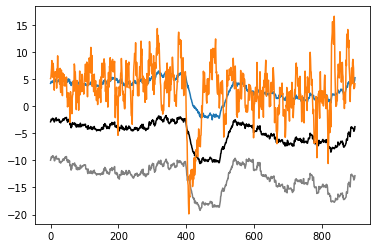

In [63]:
plt.plot(all_td1_mean)
plt.plot(np.array(all_td1_mean)-0.5*np.array(all_td1_sd),'k')
plt.plot(np.array(all_td1_mean)-np.array(all_td1_sd),color='gray')
plt.plot(all_td2_mean)

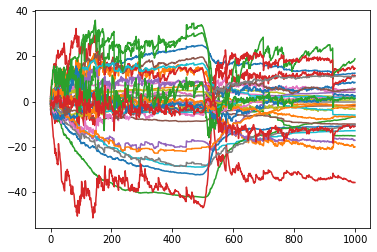

In [64]:
all_weights_array = np.stack(all_weights)
np.squeeze(all_weights_array).shape
plt.plot(np.squeeze(all_weights_array));

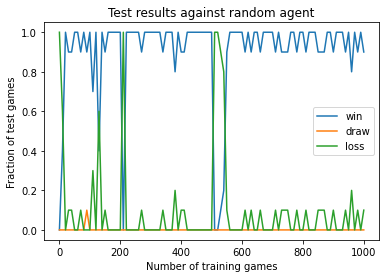

In [65]:
loss_rand = 1-np.array(test_results_rand)-np.array(test_draws_rand)
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_results_rand,label='win'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_draws_rand,label='draw'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),loss_rand,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against random agent');

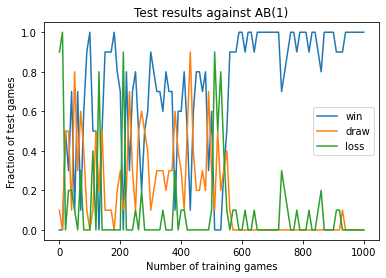

In [66]:
loss_1 = 1-np.array(test_results_1)-np.array(test_draws_1)
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_results_1,label='win'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_draws_1,label='draw'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),loss_1,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against AB(1)');

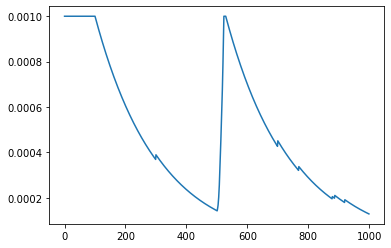

In [67]:
plt.plot(range(1000), all_alpha)

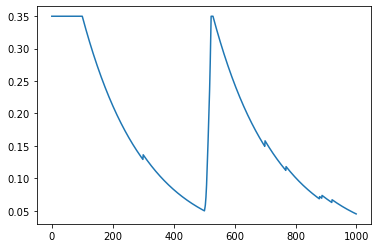

In [68]:
plt.plot(range(1000), all_epsilon)

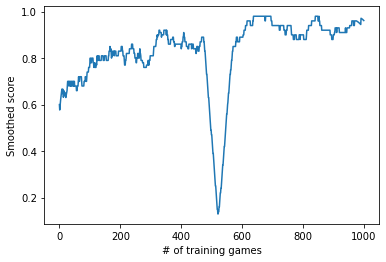

In [69]:
w = 50
calib = np.convolve(np.ones(n_train_games+n_train_games_post_reversal), np.ones(w), 'same')
all_score = 1*np.array(all_results) + 0.5*np.array(all_draws)
mean_smooth_score = np.convolve(all_score, np.ones(w), 'same') / calib
plt.plot(mean_smooth_score)
plt.xlabel('# of training games')
plt.ylabel('Smoothed score');

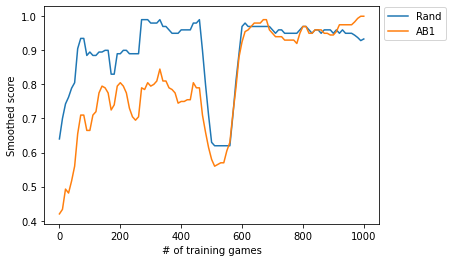

In [70]:
w = 10
calib = np.convolve(np.ones(len(test_results_rand)), np.ones(w), 'same')
all_score_rand = 1*np.array(test_results_rand) + 0.5*np.array(test_draws_rand)
all_score_1 = 1*np.array(test_results_1) + 0.5*np.array(test_draws_1)

mean_smooth_score_rand = np.convolve(all_score_rand, np.ones(w), 'same') / calib
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),mean_smooth_score_rand, label='Rand')
mean_smooth_score_1 = np.convolve(all_score_1, np.ones(w), 'same') / calib
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),mean_smooth_score_1, label='AB1')
plt.legend(bbox_to_anchor=(1,1.02))
plt.xlabel('# of training games')
plt.ylabel('Smoothed score');

In [71]:
n_features = 34
feature_func = checkers_features_augmented

reward_function = checkers_reward
reverse_reward_function = reverse_checkers_reward

ab1 = AlphaBetaAgent(1)
ab2 = AlphaBetaAgent(2)
ab3 = AlphaBetaAgent(3)
rand_agent = RandomAgent()
second_agent_list = [ab1, ab2, ab3, rand_agent]
# second_agent_list = [ab1, rand_agent]

ab1_r = AlphaBetaAgent(1, reward_direction=-1)
ab2_r = AlphaBetaAgent(2, reward_direction=-1)
ab3_r = AlphaBetaAgent(3, reward_direction=-1)        
second_agent_list_post_reversal = [ab1_r, ab2_r, ab3_r, rand_agent]
# second_agent_list_post_reversal = [ab1_r, rand_agent]

quiet = True
n_train_games = 500
n_train_games_post_reversal = 500
max_moves = 500
n_decay = 1
n_games_test = 10
test_frequency = 10
max_random_start_depth_train = 3
max_random_start_depth_test = 3
gamma = 0.7
min_alpha = 1e-5
min_epsilon = 0.01
alpha_decay_rate = 0.995
epsilon_decay_rate = 0.995
alpha_recovery_rate = 1.05
epsilon_recovery_rate = 1.05

w1 = 100
w2 = 10
sd_frac = 0.5

In [72]:
pool_results = []
pool_draws = []
pool_oppn_idx = []
pool_weights = []
pool_rewards = []
pool_td = []
pool_num = []
pool_test_results_rand = []
pool_test_results_1 = []
pool_test_results_2 = []
pool_test_results_3 = []
pool_test_draws_rand = []
pool_test_draws_1 = []
pool_test_draws_2 = []
pool_test_draws_3 = []

pool_td1_mean = []
pool_td1_sd = []
pool_td2_mean = []

pool_alpha = []
pool_epsilon = []
    
for i_trial in [0]:
    print('Trial =', i_trial)
    
    np.random.seed(i_trial)
    initial_weights = np.random.normal(size=n_features)
    first_agent = SarsaLearningAgent(feature_func, n_features, reward_function = reward_function, alpha=initial_alpha, gamma=gamma, epsilon=initial_epsilon, is_learning_agent=True, weights=initial_weights)

    all_results = []
    all_draws = []
    all_oppn_idx = []
    all_weights = []
    all_rewards = []
    all_td = []
    all_num = []
    test_results_rand = []
    test_results_1 = []
    test_results_2 = []
    test_results_3 = []
    test_draws_rand = []
    test_draws_1 = []
    test_draws_2 = []
    test_draws_3 = []
    
    all_td1_mean = []
    all_td1_sd = []
    all_td2_mean = []
    all_alpha = []
    all_epsilon = []

    # pre-training test
    this_test_results_rand = []
    this_test_results_1 = []
    this_test_results_2 = []
    this_test_results_3 = []

    this_test_draws_rand = []
    this_test_draws_1 = []
    this_test_draws_2 = []
    this_test_draws_3 = []

    for n in range(n_games_test):
        test_agent = SarsaLearningAgent(feature_func, n_features, reward_function = reward_function, alpha=0., gamma=gamma, epsilon=initial_epsilon, is_learning_agent=False, weights=initial_weights)
        # play against ab1
        first_agent_turn = bool(np.random.binomial(1,0.5))
        rules = ClassicGameRules(max_moves=max_moves)
        game = rules.new_game(test_agent, ab1, first_agent_turn, quiet=quiet)

        # random start
        random_start_spots = game.game_state.board.spots
        for _ in range(np.random.choice(max_random_start_depth_test)*2):
            possible_moves = game.game_state.board.get_possible_next_moves()
            next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
            game.game_state.board.make_move(next_move, switch_player_turn=True)
            random_start_spots = game.game_state.board.spots

        num_moves, game_state = game.run()
        this_test_results_1.append(game_state.is_first_agent_win())
        this_test_draws_1.append(game_state.max_moves_done)

        # play against ab2
        first_agent_turn = bool(np.random.binomial(1,0.5))
        rules = ClassicGameRules(max_moves=max_moves)
        game = rules.new_game(test_agent, ab2, first_agent_turn, quiet=quiet)
        game.game_state.board.spots = random_start_spots # set start board position to the same random start
        num_moves, game_state = game.run()
        this_test_results_2.append(game_state.is_first_agent_win())
        this_test_draws_2.append(game_state.max_moves_done)

        # play against ab3
        first_agent_turn = bool(np.random.binomial(1,0.5))
        rules = ClassicGameRules(max_moves=max_moves)
        game = rules.new_game(test_agent, ab3, first_agent_turn, quiet=quiet)
        game.game_state.board.spots = random_start_spots # set start board position to the same random start
        num_moves, game_state = game.run()
        this_test_results_3.append(game_state.is_first_agent_win())
        this_test_draws_3.append(game_state.max_moves_done)

        # play against random agent
        first_agent_turn = bool(np.random.binomial(1,0.5))
        rules = ClassicGameRules(max_moves=max_moves)
        game = rules.new_game(test_agent, rand_agent, first_agent_turn, quiet=quiet)
        game.game_state.board.spots = random_start_spots # set start board position to the same random start
        num_moves, game_state = game.run()
        this_test_results_rand.append(game_state.is_first_agent_win())
        this_test_draws_rand.append(game_state.max_moves_done)

    test_results_1.append(np.mean(np.array(this_test_results_1)))
    test_results_2.append(np.mean(np.array(this_test_results_2)))
    test_results_3.append(np.mean(np.array(this_test_results_3)))
    test_results_rand.append(np.mean(np.array(this_test_results_rand)))

    test_draws_1.append(np.mean(np.array(this_test_draws_1)))
    test_draws_2.append(np.mean(np.array(this_test_draws_2)))
    test_draws_3.append(np.mean(np.array(this_test_draws_3)))
    test_draws_rand.append(np.mean(np.array(this_test_draws_rand)))


    # training with standard rule
    for n in range(n_train_games):
        if n > w1:
            mean_td_1 = np.mean(all_td[-w1:])
            sd_td_1 = np.std(all_td[-w1:])
            mean_td_2 = np.mean(all_td[-w2:])
            
            all_td1_mean.append(mean_td_1)
            all_td1_sd.append(sd_td_1)
            all_td2_mean.append(mean_td_2)
            
            # increase learning rate if TD decreased
            if mean_td_2 < (mean_td_1 - sd_frac*sd_td_1):
                factor = (mean_td_1 - mean_td_2)/(sd_frac*sd_td_1)
                current_alpha = first_agent.alpha
                current_epsilon = first_agent.epsilon
                first_agent.alpha = min([(alpha_recovery_rate**factor)*current_alpha, initial_alpha])
                first_agent.epsilon = min([(alpha_recovery_rate**factor)*current_epsilon, initial_epsilon])
                print('Ajusting alpha from {0:.6f} to {1:.6f}'.format(current_alpha,first_agent.alpha))
                print('Ajusting epsilon from {0:.6f} to {1:.6f}'.format(current_epsilon,first_agent.epsilon))
                
            # change alpha and epsilon after n_decay games
            elif n%n_decay == n_decay-1:
                first_agent.alpha = max([alpha_decay_rate*first_agent.alpha, min_alpha])
                first_agent.epsilon = max([epsilon_decay_rate*first_agent.epsilon, min_epsilon])

#         if n%50 == 0: print(n)
        # train against randomly selected agent
        first_agent_turn = bool(np.random.binomial(1,0.5))

        second_agent_idx = np.random.choice(len(second_agent_list))  
        all_oppn_idx.append(second_agent_idx)
        second_agent = second_agent_list[second_agent_idx]

        rules = ClassicGameRules(max_moves=max_moves)
        game = rules.new_game(first_agent, second_agent, first_agent_turn, quiet=quiet)    

        # random start
        for _ in range(np.random.choice(max_random_start_depth_train)*2):
            possible_moves = game.game_state.board.get_possible_next_moves()
            next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
            game.game_state.board.make_move(next_move, switch_player_turn=True)

        num_moves, game_state = game.run()

        all_num.append(num_moves)
        all_rewards.append(first_agent.episode_rewards)
        all_td.append(first_agent.episode_td_history[-1])
        all_results.append(game_state.is_first_agent_win())
        all_draws.append((game_state.max_moves_done))
        all_weights.append(first_agent.weights.copy())
        all_alpha.append(first_agent.alpha)
        all_epsilon.append(first_agent.epsilon)

        if n%test_frequency == test_frequency-1:

            this_test_results_rand = []
            this_test_results_1 = []
            this_test_results_2 = []
            this_test_results_3 = []

            this_test_draws_rand = []
            this_test_draws_1 = []
            this_test_draws_2 = []
            this_test_draws_3 = []

            for _ in range(n_games_test):
                current_epislon = first_agent.epsilon
                test_agent = SarsaLearningAgent(feature_func, n_features, reward_function = reward_function, alpha=0., gamma=gamma, epsilon=current_epislon, is_learning_agent=False, weights=all_weights[-1])
                # play against ab1
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, ab1, first_agent_turn, quiet=quiet)

                # random start
                random_start_spots = game.game_state.board.spots
                for _ in range(np.random.choice(max_random_start_depth_test)*2):
                    possible_moves = game.game_state.board.get_possible_next_moves()
                    next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
                    game.game_state.board.make_move(next_move, switch_player_turn=True)
                    random_start_spots = game.game_state.board.spots

                num_moves, game_state = game.run()
                this_test_results_1.append(game_state.is_first_agent_win())
                this_test_draws_1.append(game_state.max_moves_done)

                # play against ab2
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, ab2, first_agent_turn, quiet=quiet)
                game.game_state.board.spots = random_start_spots # set start board position to the same random start
                num_moves, game_state = game.run()
                this_test_results_2.append(game_state.is_first_agent_win())
                this_test_draws_2.append(game_state.max_moves_done)

                # play against ab3
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, ab3, first_agent_turn, quiet=quiet)
                game.game_state.board.spots = random_start_spots # set start board position to the same random start
                num_moves, game_state = game.run()
                this_test_results_3.append(game_state.is_first_agent_win())
                this_test_draws_3.append(game_state.max_moves_done)

                # play against random agent
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, rand_agent, first_agent_turn, quiet=quiet)
                game.game_state.board.spots = random_start_spots # set start board position to the same random start
                num_moves, game_state = game.run()
                this_test_results_rand.append(game_state.is_first_agent_win())
                this_test_draws_rand.append(game_state.max_moves_done)

            test_results_1.append(np.mean(np.array(this_test_results_1)))
            test_results_2.append(np.mean(np.array(this_test_results_2)))
            test_results_3.append(np.mean(np.array(this_test_results_3)))
            test_results_rand.append(np.mean(np.array(this_test_results_rand)))

            test_draws_1.append(np.mean(np.array(this_test_draws_1)))
            test_draws_2.append(np.mean(np.array(this_test_draws_2)))
            test_draws_3.append(np.mean(np.array(this_test_draws_3)))
            test_draws_rand.append(np.mean(np.array(this_test_draws_rand)))

#             print('Post game', n,'wins = ',test_results_1[-1],test_results_rand[-1])    
#             print('Post game', n,'draws = ',test_draws_1[-1],test_draws_rand[-1]) 
            
            print('Post game', n, 'wins = ',test_results_1[-1],test_results_2[-1],test_results_3[-1],test_results_rand[-1])    
            print('Post game', n,'draws = ',test_draws_1[-1],test_draws_2[-1],test_draws_3[-1],test_draws_rand[-1])  
            
  
    
    #### set reverse rule (in ClassicGameRules.new_game)
    reverse = True

    # RL agent: takes reverse reward
    first_agent = SarsaLearningAgent(feature_func, n_features, reward_function = reverse_reward_function, 
                                     alpha=all_alpha[-1], gamma=gamma, epsilon=all_epsilon[-1], 
                                     is_learning_agent=True, weights=all_weights[n_train_games-1])
    
    # train with reverse rule
    for n in range(n_train_games_post_reversal):    
        # start readjusting mechanisms immediately
        mean_td_1 = np.mean(all_td[-w1:])
        sd_td_1 = np.std(all_td[-w1:])
        mean_td_2 = np.mean(all_td[-w2:])

        all_td1_mean.append(mean_td_1)
        all_td1_sd.append(sd_td_1)
        all_td2_mean.append(mean_td_2)
        
        # increase learning rate if TD decreased
        if mean_td_2 < (mean_td_1 - sd_frac*sd_td_1):
            factor = (mean_td_1 - mean_td_2)/(sd_frac*sd_td_1)
            current_alpha = first_agent.alpha
            current_epsilon = first_agent.epsilon
            first_agent.alpha = min([(alpha_recovery_rate**factor)*current_alpha, initial_alpha])
            first_agent.epsilon = min([(alpha_recovery_rate**factor)*current_epsilon, initial_epsilon])
            print('Ajusting alpha from {0:.6f} to {1:.6f}'.format(current_alpha,first_agent.alpha))
            print('Ajusting epsilon from {0:.6f} to {1:.6f}'.format(current_epsilon,first_agent.epsilon))

        # change alpha and epsilon after n_decay games
        elif n%n_decay == n_decay-1:
            first_agent.alpha = max([alpha_decay_rate*first_agent.alpha, min_alpha])
            first_agent.epsilon = max([epsilon_decay_rate*first_agent.epsilon, min_epsilon])
            
        # train against randomly selected agent
        first_agent_turn = bool(np.random.binomial(1,0.5))

        second_agent_idx = np.random.choice(len(second_agent_list_post_reversal))  
        all_oppn_idx.append(second_agent_idx)
        second_agent = second_agent_list_post_reversal[second_agent_idx]

        rules = ClassicGameRules(max_moves=max_moves)
        game = rules.new_game(first_agent, second_agent, first_agent_turn, quiet=quiet, reverse=reverse)    

        # random start
        for _ in range(np.random.choice(max_random_start_depth_train)*2):
            possible_moves = game.game_state.board.get_possible_next_moves()
            next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
            game.game_state.board.make_move(next_move, switch_player_turn=True)

        num_moves, game_state = game.run()

        all_num.append(num_moves)
        all_rewards.append(first_agent.episode_rewards)
        all_results.append(game_state.is_first_agent_win())
        all_td.append(first_agent.episode_td_history[-1])
        all_draws.append((game_state.max_moves_done))
        all_weights.append(first_agent.weights.copy())
        all_alpha.append(first_agent.alpha)
        all_epsilon.append(first_agent.epsilon)

        if n%test_frequency == test_frequency-1:

            this_test_results_rand = []
            this_test_results_1 = []
            this_test_results_2 = []
            this_test_results_3 = []

            this_test_draws_rand = []
            this_test_draws_1 = []
            this_test_draws_2 = []
            this_test_draws_3 = []

            for _ in range(n_games_test):
                current_epislon = first_agent.epsilon
                test_agent = SarsaLearningAgent(feature_func, n_features, reward_function = reverse_checkers_reward, 
                                                alpha=0., gamma=gamma, epsilon=current_epislon, 
                                                is_learning_agent=False, weights=all_weights[-1])
                # play against ab1_r
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, ab1_r, first_agent_turn, quiet=quiet, reverse=reverse)

                # random start
                random_start_spots = game.game_state.board.spots
                for _ in range(np.random.choice(max_random_start_depth_test)*2):
                    possible_moves = game.game_state.board.get_possible_next_moves()
                    next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
                    game.game_state.board.make_move(next_move, switch_player_turn=reverse)
                    random_start_spots = game.game_state.board.spots

                num_moves, game_state = game.run()
                this_test_results_1.append(game_state.is_first_agent_win())
                this_test_draws_1.append(game_state.max_moves_done)

                # play against ab2_r
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, ab2_r, first_agent_turn, quiet=quiet, reverse=reverse)
                game.game_state.board.spots = random_start_spots # set start board position to the same random start
                num_moves, game_state = game.run()
                this_test_results_2.append(game_state.is_first_agent_win())
                this_test_draws_2.append(game_state.max_moves_done)

                # play against ab3_r
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, ab3_r, first_agent_turn, quiet=quiet, reverse=reverse)
                game.game_state.board.spots = random_start_spots # set start board position to the same random start
                num_moves, game_state = game.run()
                this_test_results_3.append(game_state.is_first_agent_win())
                this_test_draws_3.append(game_state.max_moves_done)

                # play against random agent
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, rand_agent, first_agent_turn, quiet=quiet, reverse=True)
                game.game_state.board.spots = random_start_spots # set start board position to the same random start
                num_moves, game_state = game.run()
                this_test_results_rand.append(game_state.is_first_agent_win())
                this_test_draws_rand.append(game_state.max_moves_done)

            test_results_1.append(np.mean(np.array(this_test_results_1)))
            test_results_2.append(np.mean(np.array(this_test_results_2)))
            test_results_3.append(np.mean(np.array(this_test_results_3)))
            test_results_rand.append(np.mean(np.array(this_test_results_rand)))

            test_draws_1.append(np.mean(np.array(this_test_draws_1)))
            test_draws_2.append(np.mean(np.array(this_test_draws_2)))
            test_draws_3.append(np.mean(np.array(this_test_draws_3)))
            test_draws_rand.append(np.mean(np.array(this_test_draws_rand)))

#             print('Post reverse game', n,'wins = ',test_results_1[-1],test_results_rand[-1])    
#             print('Post reverse game', n,'draws = ',test_draws_1[-1],test_draws_rand[-1]) 
            
            print('Post reverse game', n,'wins = ',test_results_1[-1],test_results_2[-1],test_results_3[-1],test_results_rand[-1])    
            print('Post reverse game', n,'draws = ',test_draws_1[-1],test_draws_2[-1],test_draws_3[-1],test_draws_rand[-1]) 
        
#     data = {'all_results':all_results,
#             'all_draws':all_draws,
#             'all_oppn_idx':all_oppn_idx,
#             'all_num':all_num,
#             'all_weights':all_weights,
#             'all_rewards':all_rewards,
#             'all_td':all_td,
#             'test_results_rand':test_results_rand,
#             'test_results_1':test_results_1,
#             'test_results_2':test_results_2,
#             'test_results_3':test_results_3,
#             'test_draws_rand':test_draws_rand,
#             'test_draws_1':test_draws_1,
#             'test_draws_2':test_draws_2,
#             'test_draws_3':test_draws_3}
    
#     filename = 'Results_{0}_Experiment_SARSA_33_features_checker_reward_mix_oppn_reverse_rule_at_1000_manual_tuning_alpha_eps.pkl'.format(i_trial)
#     with open(filename, "wb") as f:
#         pickle.dump(data, f)

    pool_results.append(all_results)
    pool_draws.append(all_draws)
    pool_oppn_idx.append(all_oppn_idx)
    pool_weights.append(all_weights)
    pool_rewards.append(all_rewards)
    pool_td.append(all_td)
    pool_num.append(all_num)
    pool_test_results_rand.append(test_results_rand)
    pool_test_results_1.append(test_results_1)
    pool_test_results_2.append(test_results_2)
    pool_test_results_3.append(test_results_3)
    pool_test_draws_rand.append(test_draws_rand)
    pool_test_draws_1.append(test_draws_1)
    pool_test_draws_2.append(test_draws_2)
    pool_test_draws_3.append(test_draws_3)
    pool_td1_mean.append(all_td1_mean)
    pool_td1_sd.append(all_td1_sd)
    pool_td2_mean.append(all_td2_mean)
    pool_alpha.append(all_alpha)
    pool_epsilon.append(all_epsilon)

Trial = 0
Post game 9 wins =  0.5 0.0 0.0 1.0
Post game 9 draws =  0.5 0.4 0.2 0.0
Post game 19 wins =  0.6 0.2 0.1 1.0
Post game 19 draws =  0.4 0.4 0.4 0.0
Post game 29 wins =  0.2 0.0 0.0 0.9
Post game 29 draws =  0.7 0.2 0.0 0.0
Post game 39 wins =  0.9 0.0 0.0 0.9
Post game 39 draws =  0.1 0.4 0.2 0.1
Post game 49 wins =  0.4 0.0 0.0 1.0
Post game 49 draws =  0.6 0.3 0.4 0.0
Post game 59 wins =  0.8 0.4 0.1 1.0
Post game 59 draws =  0.2 0.4 0.2 0.0
Post game 69 wins =  0.6 0.0 0.2 1.0
Post game 69 draws =  0.4 0.6 0.3 0.0
Post game 79 wins =  0.8 0.0 0.1 1.0
Post game 79 draws =  0.2 0.6 0.3 0.0
Post game 89 wins =  0.6 0.0 0.2 1.0
Post game 89 draws =  0.4 0.9 0.6 0.0
Post game 99 wins =  0.6 0.1 0.0 1.0
Post game 99 draws =  0.4 0.7 0.6 0.0
Post game 109 wins =  0.6 0.4 0.0 1.0
Post game 109 draws =  0.4 0.5 0.6 0.0
Post game 119 wins =  0.7 0.5 0.0 1.0
Post game 119 draws =  0.3 0.5 0.6 0.0
Post game 129 wins =  0.5 0.2 0.0 1.0
Post game 129 draws =  0.5 0.7 0.7 0.0
Post game 1

Ajusting alpha from 0.000171 to 0.000184
Ajusting epsilon from 0.059915 to 0.064388
Ajusting alpha from 0.000184 to 0.000195
Ajusting epsilon from 0.064388 to 0.068312
Ajusting alpha from 0.000195 to 0.000207
Ajusting epsilon from 0.068312 to 0.072400
Ajusting alpha from 0.000207 to 0.000218
Ajusting epsilon from 0.072400 to 0.076195
Post reverse game 279 wins =  1.0 0.3 0.0 0.9
Post reverse game 279 draws =  0.0 0.2 0.1 0.0
Ajusting alpha from 0.000218 to 0.000229
Ajusting epsilon from 0.076195 to 0.080066
Ajusting alpha from 0.000228 to 0.000239
Ajusting epsilon from 0.079666 to 0.083709
Post reverse game 289 wins =  0.9 0.4 0.0 1.0
Post reverse game 289 draws =  0.1 0.4 0.4 0.0
Post reverse game 299 wins =  0.7 0.2 0.0 0.9
Post reverse game 299 draws =  0.3 0.2 0.1 0.0
Post reverse game 309 wins =  0.9 0.6 0.0 0.9
Post reverse game 309 draws =  0.1 0.0 0.6 0.0
Post reverse game 319 wins =  0.8 0.4 0.0 1.0
Post reverse game 319 draws =  0.1 0.2 0.2 0.0
Post reverse game 329 wins =  0

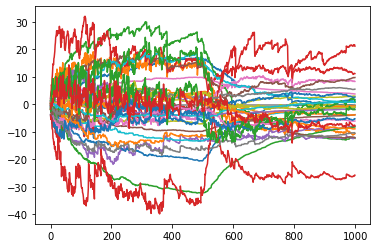

In [82]:
all_weights_array = np.stack(all_weights)
np.squeeze(all_weights_array).shape
plt.plot(np.squeeze(all_weights_array));

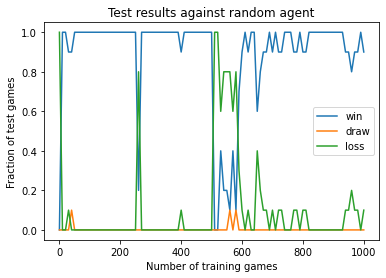

In [83]:
loss_rand = 1-np.array(test_results_rand)-np.array(test_draws_rand)
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_results_rand,label='win'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_draws_rand,label='draw'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),loss_rand,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against random agent');

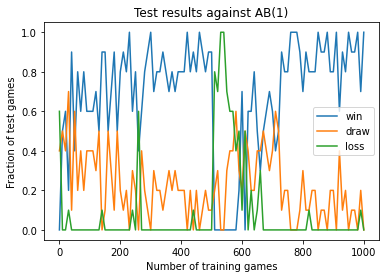

In [84]:
loss_1 = 1-np.array(test_results_1)-np.array(test_draws_1)
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_results_1,label='win'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_draws_1,label='draw'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),loss_1,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against AB(1)');

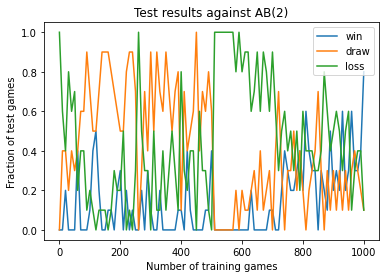

In [85]:
loss_2 = 1-np.array(test_results_2)-np.array(test_draws_2)
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_results_2,label='win'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_draws_2,label='draw'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),loss_2,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against AB(2)');

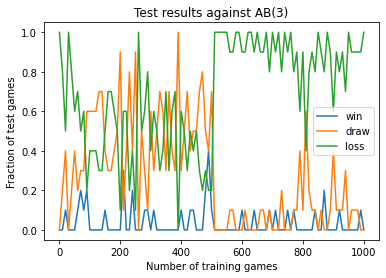

In [86]:
loss_3 = 1-np.array(test_results_3)-np.array(test_draws_3)
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_results_3,label='win'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_draws_3,label='draw'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),loss_3,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against AB(3)');

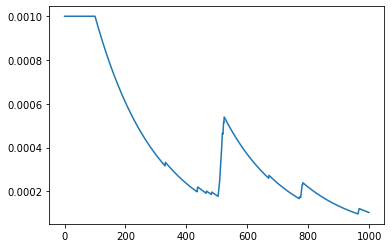

In [87]:
plt.plot(range(1000), all_alpha)

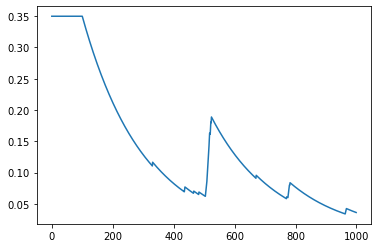

In [88]:
plt.plot(range(1000), all_epsilon)

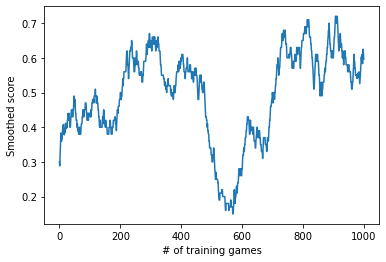

In [98]:
w = 50
calib = np.convolve(np.ones(n_train_games+n_train_games_post_reversal), np.ones(w), 'same')
all_score = 1*np.array(all_results) + 0.5*np.array(all_draws)
mean_smooth_score = np.convolve(all_score, np.ones(w), 'same') / calib
plt.plot(mean_smooth_score)
plt.xlabel('# of training games')
plt.ylabel('Smoothed score');

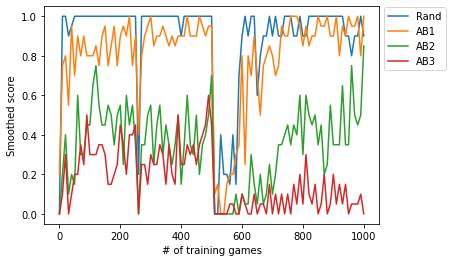

In [96]:
w = 1
calib = np.convolve(np.ones(len(test_results_rand)), np.ones(w), 'same')
all_score_rand = 1*np.array(test_results_rand) + 0.5*np.array(test_draws_rand)
all_score_1 = 1*np.array(test_results_1) + 0.5*np.array(test_draws_1)
all_score_2 = 1*np.array(test_results_2) + 0.5*np.array(test_draws_2)
all_score_3 = 1*np.array(test_results_3) + 0.5*np.array(test_draws_3)
mean_smooth_score_rand = np.convolve(all_score_rand, np.ones(w), 'same') / calib
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),mean_smooth_score_rand, label='Rand')
mean_smooth_score_1 = np.convolve(all_score_1, np.ones(w), 'same') / calib
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),mean_smooth_score_1, label='AB1')
mean_smooth_score_2 = np.convolve(all_score_2, np.ones(w), 'same') / calib
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),mean_smooth_score_2,label='AB2')
mean_smooth_score_3 = np.convolve(all_score_3, np.ones(w), 'same') / calib
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),mean_smooth_score_3,label='AB3')
plt.legend(bbox_to_anchor=(1,1.02))
plt.xlabel('# of training games')
plt.ylabel('Smoothed score');